### Trying to cluster

In [11]:
import functions

import os
import scipy.io
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# for clustering
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

# for statistical tests
from scipy.stats import ttest_rel, ttest_ind
from statsmodels.stats.multitest import multipletests
import numpy as np

In [2]:
rsfMRI_info = pd.read_excel("data/TiMeS_rsfMRI_info.xlsx", engine="openpyxl")  
regression_info = pd.read_excel("data/TiMeS_regression_info_processed.xlsx", engine="openpyxl")
rsfMRI_full_info = pd.read_excel("data/TiMeS_rsfMRI_full_info.xlsx", engine="openpyxl")
print(regression_info.columns)
print(rsfMRI_info)
regression_info=regression_info[['Stroke_location', 'Lesion_side', 'lesion_volume_mm3']]

Index(['subject_full_id', 'TimePoint', 'Behavioral_assessment', 'MRI',
       'Gender', 'Age', 'Education_level', 'Lesion_side_old', 'Lesion_side',
       'Combined', 'Bilateral', 'Comments', 'Stroke_location',
       'lesion_volume_mm3', 'NIHSS', 'FAB_abstraction', 'FAB_flexibility',
       'FAB_programmation', 'FAB_sensitivity_to_interference',
       'FAB_inhibitory_control', 'FAB_environmental_autonomy', 'FAB_TOT',
       'Stroop_color_time', 'Stroop_color_error', 'Stroop_words_time',
       'Stroop_words_error', 'Stroop_interference_time',
       'Stroop_interference_error', 'Stroop_index_WC', 'Stroop_index_InC',
       'Digit_forward_SPAN', 'Digit_forward_TOTAL', 'Digit_backward_SPAN',
       'Digit_backward_TOTAL', 'Digit_sequencing_SPAN',
       'Digit_sequencing_TOTAL', 'Digit_TOTAL',
       'Fugl_Meyer_right_UPPER_EXTREMITY', 'Fugl_Meyer_right_WRIST',
       'Fugl_Meyer_right_HAND', 'Fugl_Meyer_right_COORDINATION_SPEED',
       'Fugl_Meyer_right_TOTAL', 'Fugl_Meyer_left_UPPER

In [ ]:
# Folder containing the data
folder_path = "FC_matrices_times_wp11/"

# keep only ROIS
rois = [363, 364, 365, 368, 372, 373, 374, 377, 379, 361, 370, 362, 371, 10, 11, 12, 54, 56, 78, 96, 190, 191, 192, 234, 236, 258, 276, 8, 9, 51, 52, 53, 188, 189, 231, 232, 233]
rois = [roi - 1 for roi in rois]

t1_matrices, regression_info, rsfMRI_full_info, t1_subjects = functions.load_data(folder_path, rois, type='t1_only')
all_matrices, regression_info, rsfMRI_full_info, all_subjects = functions.load_data(folder_path, rois, type='all')
t1_t3_matched, regression_info, rsfMRI_full_info, t1_t3_subjects = functions.load_data(folder_path, rois, type='t1_t3_matched')
t1_t4_matched, regression_info, rsfMRI_full_info, t1_t4_subjects = functions.load_data(folder_path, rois, type='t1_t4_matched')
t1_t3_matrices, regression_info, rsfMRI_full_info, t1_t3_subjects = functions.load_data(folder_path, rois, type='t1_t3')
t1_t4_matrices, regression_info, rsfMRI_full_info, t1_t4_subjects = functions.load_data(folder_path, rois, type='t1_t4')
#matrices = functions.matrices_to_wide_df(matrices)

In [ ]:
def load_data(folder_path, rois, type = 'all'):
    '''
    Load data from .mat files in the specified folder. Either get all matrices (enter type = 'all'), 
    or only T1 matrices (enter type = 't1_only'), or only T1 and T3 matrices matched (enter type = 't1_t3_matched),
    or only T1 and T4 matrices matched (enter type = 't1_t4_matched), or all T1 and T3 matrices (enter type = 't1_t3'),
    or or all T1 and T4 matrices (enter type = 't1_t4').
    '''
    # Load Excel files
    regression_info = pd.read_excel("data/TiMeS_regression_info_processed.xlsx", engine="openpyxl")
    rsfMRI_full_info = pd.read_excel("data/TiMeS_rsfMRI_full_info.xlsx", engine="openpyxl")

    # Keep only the first appearance of each subject_full_id
    subject_info = regression_info.copy().drop_duplicates(subset=["subject_full_id"], keep="first")

    # Merge on subject_full_id
    rsfMRI_full_info = rsfMRI_full_info.merge(subject_info, on="subject_full_id", how="left")
    rsfMRI_full_info = rsfMRI_full_info[['subject_full_id', 'Lesion_side', 'Stroke_location', 'lesion_volume_mm3','Gender','Age','Education_level','Combined', 'Bilateral']]
    rsfMRI_full_info['subject_id'] = rsfMRI_full_info['subject_full_id'].astype(str).str[-4:] # Extract last 4 characters of subject_id to match with folder names and subjects
    
    # Extract last 4 characters of subject_id
    valid_subjects = rsfMRI_full_info["subject_id"].tolist()

    # Match folders with valid subject_id
    subjects = [sub for sub in os.listdir(folder_path) if sub in valid_subjects and not sub.startswith('.')]

    data_rows = []

    for sub in subjects:
        sub_folder = os.path.join(folder_path, sub)
        files = [f for f in os.listdir(sub_folder) if f.endswith('.mat')]

        t1_matrix = None
        t2_matrix = None
        t3_matrix = None
        t4_matrix = None

        for mat_file in files:
            mat_file_path = os.path.join(sub_folder, mat_file)

            # Load the matrix
            mat_data = scipy.io.loadmat(mat_file_path)
            if 'CM' not in mat_data:
                continue

            matrix = pd.DataFrame(mat_data['CM']).iloc[rois, rois]
            matrix = matrix.replace('None', np.nan)

            # Add a column with the original ROI numbers
            matrix['Original_ROI'] = rois

            if 'T1' in mat_file:
                t1_matrix = matrix
            elif 'T2' in mat_file:
                t2_matrix = matrix
            elif 'T3' in mat_file:
                t3_matrix = matrix
            elif 'T4' in mat_file:
                t4_matrix = matrix

        data_rows.append({
            "subject_id": sub,
            "T1_matrix": t1_matrix,
            "T2_matrix": t2_matrix,
            "T3_matrix": t3_matrix,
            "T4_matrix": t4_matrix
        })

    # Create dataframe
    df = pd.DataFrame(data_rows)
        # Merge the DataFrame with rsfMRI_info on subject_id
    df = df.merge(rsfMRI_full_info, on="subject_id", how="left")
    
    if type == 't1_only':
        t1_matrices = df.drop(columns=['T2_matrix', 'T3_matrix', 'T4_matrix'])

        return t1_matrices, regression_info, rsfMRI_full_info, subjects
    
    return df

Better to keep T1 and T3 as more subjects have these two !
From now on I'll work with matrices

In [4]:
print("matrices column names: ", t1_t3_matrices.columns)

matrices column names:  Index(['subject_id', 'T1_matrix', 'T3_matrix', 'subject_full_id',
       'Lesion_side', 'Stroke_location', 'lesion_volume_mm3', 'Gender', 'Age',
       'Education_level', 'Combined', 'Bilateral'],
      dtype='object')


##### Cluster for all matrices

Index(['Lesion_side_R', 'Lesion_side_R/L', 'Stroke_location_basal ganglia',
       'Stroke_location_cerebellum', 'Stroke_location_cortical',
       'Stroke_location_cortical (insula)',
       'Stroke_location_insula + basal ganglia', 'Stroke_location_mixed',
       'Stroke_location_pons', 'Stroke_location_pons + medulla oblongata',
       'Stroke_location_subcortical',
       'Stroke_location_subcortical (maybe basal ganglia)',
       'Stroke_location_subcortical + basal ganglia', 'Gender_2.0',
       'Gender_Unknown', 'Age_36.0', 'Age_40.0', 'Age_44.0', 'Age_45.0',
       'Age_47.0', 'Age_48.0', 'Age_49.0', 'Age_54.0', 'Age_56.0', 'Age_57.0',
       'Age_59.0', 'Age_60.0', 'Age_61.0', 'Age_62.0', 'Age_63.0', 'Age_64.0',
       'Age_65.0', 'Age_66.0', 'Age_67.0', 'Age_68.0', 'Age_69.0', 'Age_70.0',
       'Age_71.0', 'Age_72.0', 'Age_73.0', 'Age_74.0', 'Age_75.0', 'Age_76.0',
       'Age_77.0', 'Age_78.0', 'Age_81.0', 'Age_82.0', 'Age_85.0', 'Age_87.0',
       'Age_88.0', 'Age_89.0', '

/Users/maylismuller/Desktop/EPFL_DOCS/Master/MA4/Project Hummel/uphummel_MA4/functions.py:169: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matrices[categorical_cols_name] = matrices[categorical_cols_name].fillna('Unknown')  # Handle missing values


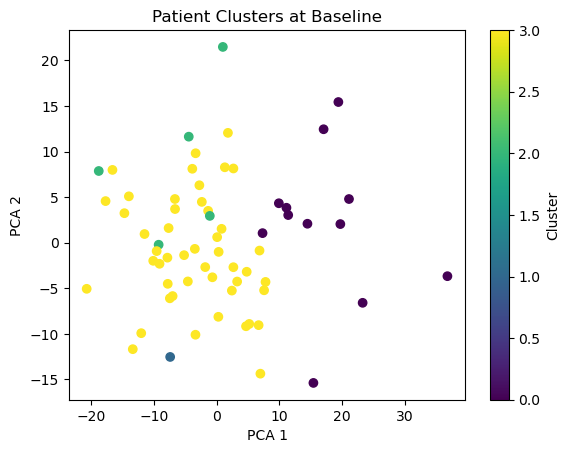

Silhouette score: 0.03264549240320621
Cluster 0: ['s063', 's012', 's015', 's082', 's071', 's003', 's033', 's045', 's042', 's080', 's073', 's086']
Cluster 1: ['s004']
Cluster 2: ['s030', 's039', 's048', 's059', 's074']
Cluster 3: ['s007', 's031', 's009', 's036', 's062', 's065', 's054', 's008', 's037', 's006', 's001', 's055', 's052', 's041', 's046', 's070', 's083', 's049', 's076', 's078', 's047', 's040', 's014', 's013', 's025', 's022', 's066', 's057', 's068', 's050', 's032', 's051', 's060', 's067', 's002', 's005', 's027', 's020', 's016', 's029', 's011', 's017', 's021', 's019', 's072', 's081', 's075']


In [5]:
categorical_cols = ['Lesion_side', 'Stroke_location','Gender','Age','Education_level','Combined', 'Bilateral']
numerical_cols = ['lesion_volume_mm3']

all_matrices_labeled = functions.cluster_and_plot(all_matrices, numerical_cols_names= numerical_cols, categorical_cols_name=categorical_cols, clusters=4)
#t1_t3_matrices_labeled = functions.cluster_and_plot(t1_t3_matrices, numerical_cols_names= numerical_cols, categorical_cols_name=categorical_cols, clusters=4)
#t1_t4_matrices_labeled = functions.cluster_and_plot(t1_t4_matrices, numerical_cols_names= numerical_cols, categorical_cols_name=categorical_cols, clusters=4)

# NORMAL THAT WE GET THE SAME CLUSTERS FOR ALL TIMEPOINTS
# because we are using the same data for clustering (T1)

shape of T1 matrices: (65, 37, 37)
shape of T3 matrices: (44, 37, 37)


/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


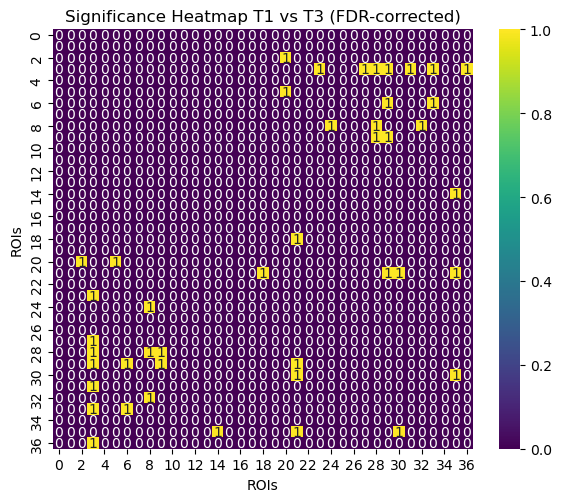

shape of T1 matrices: (65, 37, 37)
shape of T3 matrices: (44, 37, 37)


/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


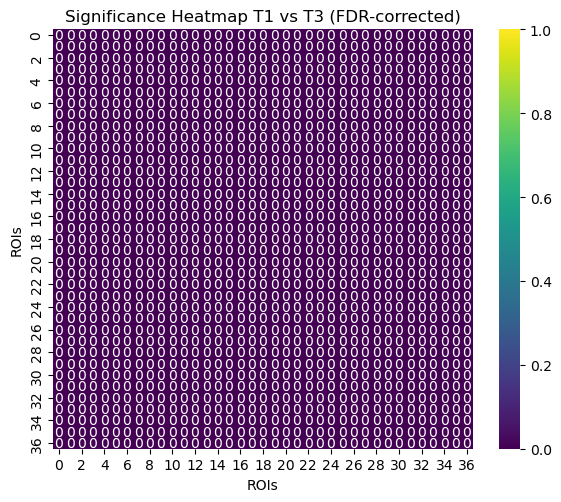

In [ ]:
significant_matrix, p_vals_corrected, reject = functions.get_sig_matrix(t1_t3_matrices, correction=False)

significant_matrix, p_vals_corrected, reject = functions.get_sig_matrix(t1_t3_matrices, correction=True)

/Users/maylismuller/Desktop/EPFL_DOCS/Master/MA4/Project Hummel/uphummel_MA4/functions.py:169: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matrices[categorical_cols_name] = matrices[categorical_cols_name].fillna('Unknown')  # Handle missing values


Index(['Lesion_side_R', 'Lesion_side_R/L', 'Stroke_location_basal ganglia',
       'Stroke_location_cerebellum', 'Stroke_location_cortical',
       'Stroke_location_cortical (insula)',
       'Stroke_location_insula + basal ganglia', 'Stroke_location_mixed',
       'Stroke_location_pons', 'Stroke_location_pons + medulla oblongata',
       'Stroke_location_subcortical',
       'Stroke_location_subcortical (maybe basal ganglia)',
       'Stroke_location_subcortical + basal ganglia', 'Gender_2.0',
       'Gender_Unknown', 'Age_36.0', 'Age_40.0', 'Age_44.0', 'Age_45.0',
       'Age_47.0', 'Age_48.0', 'Age_49.0', 'Age_54.0', 'Age_56.0', 'Age_57.0',
       'Age_59.0', 'Age_60.0', 'Age_61.0', 'Age_62.0', 'Age_63.0', 'Age_64.0',
       'Age_65.0', 'Age_66.0', 'Age_67.0', 'Age_68.0', 'Age_69.0', 'Age_70.0',
       'Age_71.0', 'Age_72.0', 'Age_73.0', 'Age_74.0', 'Age_75.0', 'Age_76.0',
       'Age_77.0', 'Age_78.0', 'Age_81.0', 'Age_82.0', 'Age_85.0', 'Age_87.0',
       'Age_88.0', 'Age_89.0', '

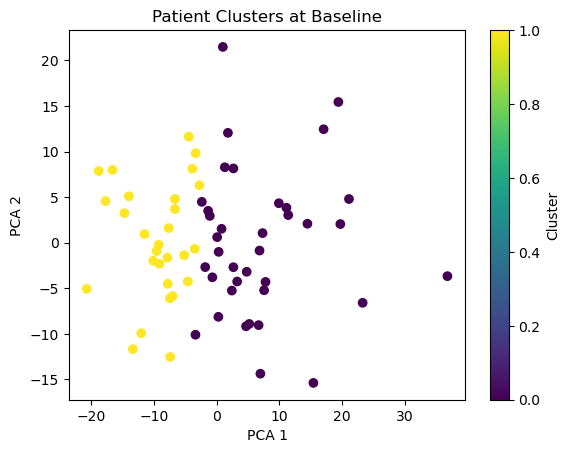

Silhouette score: 0.0738443442804258
Cluster 0: ['s007', 's036', 's062', 's065', 's037', 's039', 's001', 's052', 's063', 's083', 's012', 's015', 's082', 's071', 's047', 's014', 's013', 's025', 's022', 's059', 's068', 's050', 's003', 's060', 's033', 's002', 's029', 's045', 's042', 's080', 's073', 's017', 's021', 's072', 's086', 's081', 's075']
Cluster 1: ['s031', 's009', 's054', 's008', 's030', 's006', 's055', 's041', 's046', 's070', 's048', 's049', 's076', 's078', 's040', 's066', 's057', 's004', 's032', 's051', 's067', 's005', 's027', 's020', 's016', 's011', 's074', 's019']


In [32]:
t1_t4_matrices_labeled = functions.cluster_and_plot(t1_t4_matrices, numerical_cols_names= numerical_cols, categorical_cols_name=categorical_cols, clusters=2)

### Beginning of statistical testing

In [ ]:
from scipy.stats import ttest_rel
from statsmodels.stats.multitest import multipletests
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def compare_T1_T_by_cluster(df, tp=3, alpha=0.05):
    n_rois = t1_matrices[0].shape[0]
    results = {}

    for cluster in sorted(df['cluster'].unique()):
        print(f"\nAnalyzing Cluster {cluster}...")

        # Subset to current cluster
        cluster_df = df[df['cluster'] == cluster]

        # Ensure subjects have both T1 and T4
        cluster_df = cluster_df.dropna(subset=['T1_matrix', f'T{tp}_matrix'])

        if cluster_df.empty:
            print(f" - No data for Cluster {cluster}")
            continue

        # Flatten matrices
        X_T1 = np.array([functions.flatten_upper(m) for m in cluster_df['T1_matrix']])
        X_T4 = np.array([functions.flatten_upper(m) for m in cluster_df['T4_matrix']])

        # Paired t-test
        t_stats, p_vals = ttest_rel(X_T1, X_T4, axis=0)

        # FDR correction
        reject, p_vals_corrected, _, _ = multipletests(p_vals, alpha=alpha, method='fdr_bh')

        # Create symmetric significance matrix
        signif_matrix = np.zeros((n_rois, n_rois))
        triu_idx = np.triu_indices(n_rois, k=1)
        signif_matrix[triu_idx] = reject.astype(int)
        signif_matrix += signif_matrix.T

        # Store results
        results[cluster] = {
            'signif_matrix': signif_matrix,
            'p_corrected': p_vals_corrected,
            'rejected': reject,
        }

        # Plot
        plt.figure(figsize=(7, 6))
        sns.heatmap(signif_matrix, cmap='viridis', square=True, cbar=False)
        plt.title(f'Significant Changes (T1 vs T4) - Cluster {cluster}')
        plt.tight_layout()
        plt.show()

    return results



Analyzing Cluster 0...


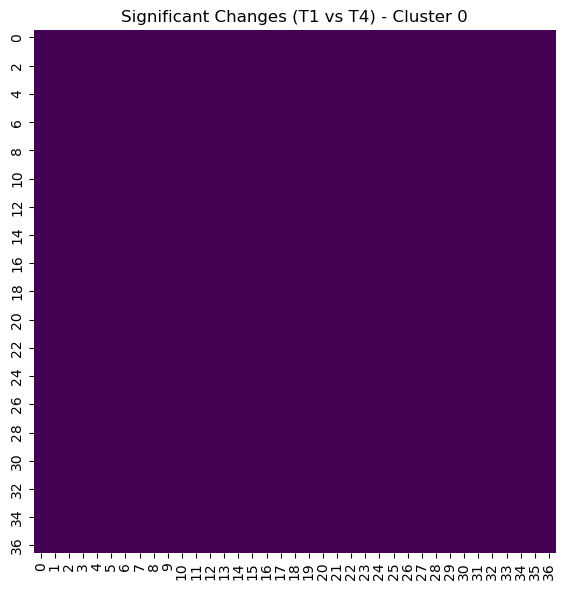


Analyzing Cluster 1...


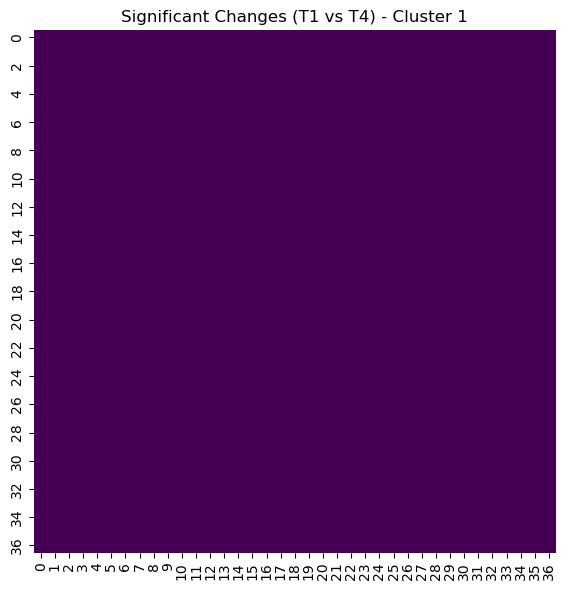

In [36]:
results = compare_T1_T4_by_cluster(t1_t4_matrices_labeled, rois, alpha=0.05)

In [37]:
def get_sig_matrix(df, tp=3, correction=True, alpha=0.05, cluster=False):
    def analyze_matrices(t1_matrices, t_matrices, n_rois, label=""):
        # Initialize arrays to store t-stats and p-values
        t_stat = np.zeros((n_rois, n_rois))
        p_val = np.ones((n_rois, n_rois))

        # Loop over each cell (i,j)
        for i in range(n_rois):
            for j in range(n_rois):
                t1_values = np.array([mat[i, j] for mat in t1_matrices])
                t_values = np.array([mat[i, j] for mat in t_matrices])

                # Perform independent t-test
                stat, p = ttest_ind(t1_values, t_values, equal_var=True)
                t_stat[i, j] = stat
                p_val[i, j] = p

        # Flatten p-values for correction
        p_val_flat = p_val.ravel()

        if correction:
            reject, p_vals_corrected, _, _ = multipletests(p_val_flat, alpha=alpha, method='fdr_bh')
        else:
            p_vals_corrected = p_val_flat
            reject = np.zeros_like(p_val_flat, dtype=bool)
            reject[p_vals_corrected < alpha] = True

        # Reshape
        p_vals_corrected = p_vals_corrected.reshape(p_val.shape)
        reject = reject.reshape(p_val.shape)

        # Create significance matrix
        significant_matrix = np.zeros_like(p_val, dtype=int)
        significant_matrix[reject] = 1

        # Plot
        plt.figure(figsize=(6, 5))
        sns.heatmap(significant_matrix, cmap='viridis', cbar=True, annot=False, square=True, vmin=0, vmax=1)
        plt.title(f"Significance Heatmap {label} (FDR-corrected: {correction})")
        plt.xlabel("ROIs")
        plt.ylabel("ROIs")
        plt.tight_layout()
        plt.show()

        return significant_matrix, p_vals_corrected, reject

    results = {}

    if not cluster:
        # Whole dataset
        t1_matrices = [matrix.values if isinstance(matrix, pd.DataFrame) else matrix for matrix in df['T1_matrix'] if matrix is not None]
        t_matrices = [matrix.values if isinstance(matrix, pd.DataFrame) else matrix for matrix in df[f'T{tp}_matrix'] if matrix is not None]

        print("Shape of T1 matrices:", np.shape(t1_matrices))
        print(f"Shape of T{tp} matrices:", np.shape(t_matrices))

        if not t1_matrices or not t_matrices:
            raise ValueError("No matrices available for T1 or T{tp}.")

        n_rois = t1_matrices[0].shape[0]

        significant_matrix, p_vals_corrected, reject = analyze_matrices(t1_matrices, t_matrices, n_rois, label=f"T1 vs T{tp}")

        return significant_matrix, p_vals_corrected, reject

    else:
        # By cluster
        clusters = sorted(df['cluster'].dropna().unique())

        for clust in clusters:
            print(f"\nAnalyzing Cluster {clust}...")

            cluster_df = df[df['cluster'] == clust]
            cluster_df = cluster_df.dropna(subset=['T1_matrix', f'T{tp}_matrix'])

            if cluster_df.empty:
                print(f" - No data for Cluster {clust}")
                continue

            t1_matrices = [matrix.values if isinstance(matrix, pd.DataFrame) else matrix for matrix in cluster_df['T1_matrix']]
            t_matrices = [matrix.values if isinstance(matrix, pd.DataFrame) else matrix for matrix in cluster_df[f'T{tp}_matrix']]

            print(f"Cluster {clust} - Shape of T1 matrices: {np.shape(t1_matrices)}")
            print(f"Cluster {clust} - Shape of T{tp} matrices: {np.shape(t_matrices)}")

            n_rois = t1_matrices[0].shape[0]

            significant_matrix, p_vals_corrected, reject = analyze_matrices(t1_matrices, t_matrices, n_rois, label=f"Cluster {clust}: T1 vs T{tp}")

            results[clust] = {
                'significant_matrix': significant_matrix,
                'p_corrected': p_vals_corrected,
                'reject': reject
            }

        return results



Analyzing Cluster 0...
Cluster 0 - Shape of T1 matrices: (19, 37, 37)
Cluster 0 - Shape of T4 matrices: (19, 37, 37)


/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


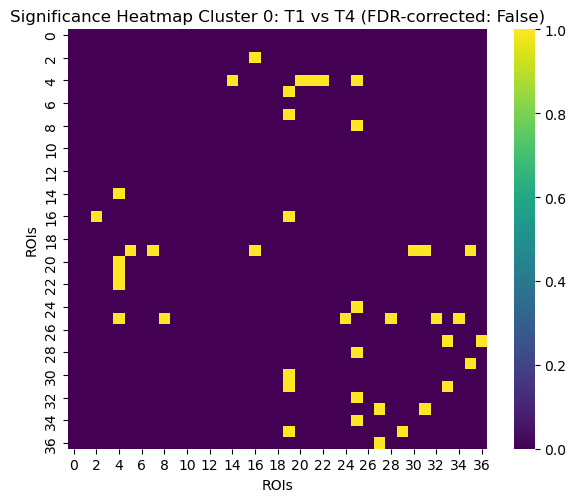


Analyzing Cluster 1...
Cluster 1 - Shape of T1 matrices: (17, 37, 37)
Cluster 1 - Shape of T4 matrices: (17, 37, 37)


/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


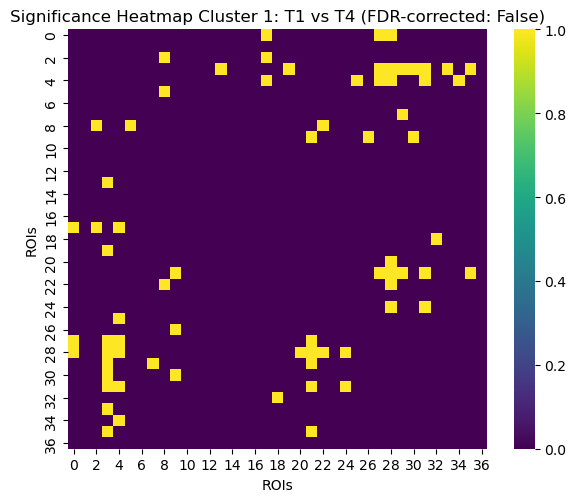

In [41]:
results = get_sig_matrix(t1_t4_matrices_labeled, tp=4, correction=False, alpha=0.05, cluster=True)

In [ ]:
functions.sig_matrix_T1_T(t1_t4_matrices_labeled, rois, tp = 4, alpha=0.05, cluster = False)

#### Code to do it by cluster for both T3 and T4

In [ ]:
functions.sig_matrix_T1_T(t1_t4_matrices_labeled, rois, tp = 4, alpha=0.05, cluster = True)

In [ ]:
functions.sig_matrix_T1_T(t1_t3_matrices_labeled, rois, tp = 3, alpha=0.05, cluster = True)

In [ ]:
t1_t3_matrices_labeled = functions.cluster_and_plot(t1_t3_matrices, numerical_cols_names= numerical_cols, categorical_cols_name=categorical_cols, clusters=2)
functions.compare_T1_T_by_cluster(t1_t3_matrices_labeled, rois, tp = 3, alpha=0.05, cluster = True)

### Look at difference between FC

In [ ]:
functions.compute_FC_diff(t1_t3_matrices_labeled, tp = 3)

### Regression Analysis